# <u>Group Project 2</u>

### Objective
In this project, we would like to estimate the announcement effect of Volcker Rule (new banking regulation in US) on US banks. More specifically, analyze at least:

- Did the banks decrease their trading assets after the announcement of the new regulation?
- If they responded to the regulation, which banks responded most and which banks least? Why?
- Remember robustness, and how should banks or regulators use these results?

### Variable Description

- <strong>rssd9001</strong>: *Banking holding company code*
- <strong>rssd9999</strong>: *time*
- <strong>bhc_avgtradingratio</strong>: *Trading asset ratio*, ratio of trading assets to total assets
- <strong>treat_3_b_avg</strong>: *Affected BHC*, dummy variable takes a value of one if the average trading asset ratio during the pre-DFA period (Q3 2004 - Q2 2009) was equal to or larger than 3%, and zero otherwise.
- <strong>after_DFA_1</strong>: *After DFA dummy*, dummy variable that equals one for all quarters between the third quarter of 2010 and the second quarter of 2015, and zero for all quarters from the third quarter of 2004 to the second quarter of 2009
- <strong>dep_roa1</strong>: *Return on assets*, net operating income divided by average total assets
- <strong>dep_leverage</strong>: *Leverage ratio*, average equity divided by average total assets
- <strong>dep_lnassets</strong>: *Total assets*, natural logarithm of total assets 
- <strong>dep_creditrisk_total3</strong>: *Non-performing loan ratio*, past due and non-accrual loans divided by total loans
- <strong>dep_cir</strong>: *Cost-income ratio*, operating expenses divided by total income
- <strong>dep_depositratio</strong>: *Deposit ratio*, average deposits divided by averagetotal assets
- <strong>dep_loans_REratio</strong>: *Real estate loan ratio*, loans secured by real estate divided by total loans
- <strong>dep_liquidity</strong>: *Liquidity ratio*, cash and balances at other depository institutions divided by total assets
- <strong>dep_cpp_bankquarter</strong>: *CPP recipient indicator*, capital Purchase Program indicator variable takes one if the bank is a current recipient of CPP funds in a given quarter, and zero otherwise.



In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import scipy.stats as stats

#################################################################################################

def ctl_trt_diff(df):
    """
    Calculates the Differences in the Mean and Standard Deviation of the Control and Treatment Group
    """
    
    int_var = [
        "dep_lnassets",
        "dep_leverage",
        "dep_roa1",
        "dep_liquidity",
        "dep_depositratio",
        "dep_loans_REratio",
        "dep_cir"
    ]

    # Calculate the group means and standard deviation
    group_mean = df.groupby("treat_3_b_avg").mean(numeric_only=True)
    group_std = df.groupby("treat_3_b_avg").std(numeric_only=True)
    
    # Extract Control result
    ctl_mean = group_mean[group_mean.index == 0]
    ctl_mean = ctl_mean[int_var].reset_index().drop(columns="treat_3_b_avg")
    ctl_sd = group_std[group_std.index == 0]
    ctl_sd = ctl_sd[int_var].reset_index().drop(columns="treat_3_b_avg")
    
    control = pd.concat([ctl_mean, ctl_sd])
    control = control.transpose()
    control.columns = pd.MultiIndex.from_tuples([('Control', 'Mean'), ('Control', 'SD')])

    # Extract Treatment result
    trt_mean = group_mean[group_mean.index == 1]
    trt_mean = trt_mean[int_var].reset_index().drop(columns="treat_3_b_avg")
    trt_sd = group_std[group_std.index == 1]
    trt_sd = trt_sd[int_var].reset_index().drop(columns="treat_3_b_avg")
    
    treatment = pd.concat([trt_mean, trt_sd])
    treatment = treatment.transpose()
    treatment.columns = pd.MultiIndex.from_tuples([('Treatment', 'Mean'), ('Treatment', 'SD')])

    # Extract Difference result
    mean_diff = ctl_mean - trt_mean
    sd_diff = ctl_sd - trt_sd
    
    diff = pd.concat([mean_diff, sd_diff])
    diff = diff. transpose()
    diff.columns = pd.MultiIndex.from_tuples([('Difference', 'Mean'), ('Difference', 'SD')])

    # Create a new DataFrame concatenating control, treatment, and diff
    result_df = pd.concat([control, treatment, diff], axis=1)
    
    return result_df

#################################################################################################

def dataplot(df):
    """
    Plots the graph of bhc_avgtradingratio with respect to time for the Control and Treatment Group
    """
    
    control_pre = df[(df["treat_3_b_avg"] == 0) & (df["after_DFA_1"] == 0)]
    treatment_pre = df[(df["treat_3_b_avg"] == 1) & (df["after_DFA_1"] == 0)]
    control_post = df[(df["treat_3_b_avg"] == 0) & (df["after_DFA_1"] == 1)]
    treatment_post = df[(df["treat_3_b_avg"] == 1) & (df["after_DFA_1"] == 1)]

    print(len(control_pre), len(treatment_pre), len(control_post), len(treatment_post))

    x_control_pre = np.sort(control_pre["time"].unique())
    y_control_pre = control_pre.groupby("rssd9999").mean(numeric_only=True)["bhc_avgtradingratio"].values

    x_treatment_pre = np.sort(treatment_pre["time"].unique())
    y_treatment_pre = treatment_pre.groupby("rssd9999").mean(numeric_only=True)["bhc_avgtradingratio"].values

    x_control_post = np.sort(control_post["time"].unique())
    y_control_post = control_post.groupby("rssd9999").mean(numeric_only=True)["bhc_avgtradingratio"].values

    x_treatment_post = np.sort(treatment_post["time"].unique())
    y_treatment_post = treatment_post.groupby("rssd9999").mean(numeric_only=True)["bhc_avgtradingratio"].values

    plt.plot(x_control_pre, y_control_pre, marker='o', linestyle='-', color='red', label='Control Pre')
    plt.plot(x_control_post, y_control_post, marker='o', linestyle='-', color='red', label='Control Post')
    plt.plot(x_treatment_pre, y_treatment_pre, marker='x', linestyle='-', color='blue', label='Treatment Pre')
    plt.plot(x_treatment_post, y_treatment_post, marker='x', linestyle='-', color='blue', label='Treatment Post')

    plt.xlabel("Time")
    plt.ylabel("Trading Asset Ratio")
    plt.grid(True)

    # Add a legend outside the graph
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
#################################################################################################
    
def new_dataplot(df):
    """
    Plots the graph of bhc_avgtradingratio with respect to time for the Control and Treatment Group
    """
    
    control_df = df[df["treat_3_b_avg"] == 0]
    treatment_df = df[df["treat_3_b_avg"] == 1]
    
    x_control = np.sort(control_df["time"].unique())
    y_control = control_df.groupby("rssd9999").mean(numeric_only=True)["bhc_avgtradingratio"].values
    
    x_treatment = np.sort(treatment_df["time"].unique())
    y_treatment = treatment_df.groupby("rssd9999").mean(numeric_only=True)["bhc_avgtradingratio"].values
    
    plt.plot(x_control, y_control, marker='o', linestyle='-', color='red', label='Control')
    plt.plot(x_treatment, y_treatment, marker='x', linestyle='-', color='blue', label='Treatment')
    plt.axvline(x=max(df[df["after_DFA_1"] == 0]["time"]), color='red', linestyle='dashed', linewidth=2)
    plt.axvline(x=min(df[df["after_DFA_1"] == 1]["time"]), color='red', linestyle='dashed', linewidth=2)
    
    plt.xlabel("Time")
    plt.ylabel("Trading Asset Ratio")
    plt.grid(True)

    # Add a legend outside the graph
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

#################################################################################################

def t_test(df):
    """
    Performs T-tests for each covariate
    """
    
    treat_group = df[(df['treat_3_b_avg'] == 1) & (df['after_DFA_1'] == 0)]
    test_group = df[(df['treat_3_b_avg'] == 0) & (df['after_DFA_1'] == 0)]
    
    covariates = [
        'bhc_avgtradingratio', 
        'dep_roa1', 
        'dep_leverage',
        'dep_lnassets',
        'dep_creditrisk_total3',
        'dep_cir','dep_depositratio',
        'dep_loans_REratio',
        'dep_liquidity',
        'dep_cpp_bankquarter'
    ]
    
    results = {}
    
    for covariate in covariates:
        t_stat, p_value = stats.ttest_ind(treat_group[covariate], test_group[covariate])
        results[covariate] = {'t-value': t_stat, 'p-value': p_value}

    return pd.DataFrame(results).transpose()

#################################################################################################

In [43]:
# Read the data from the CSV file
df = pd.read_csv("DiD_data.csv")


Here, we create a "time" column for data plotting and drop all datasets that contain NA values.

In [44]:
# process time
df['time'] = pd.to_datetime(df['rssd9999'], format='%Y%m%d')

# drop NA values
initial_row_count = df.shape[0]

df.dropna(inplace=True)

final_row_count = df.shape[0]

print(f'Initial No. of rows: {initial_row_count}')
print(f'Final No. of rows: {final_row_count}')
print(f'No. of rows dropped: {initial_row_count - final_row_count}')

df

Initial No. of rows: 81560
Final No. of rows: 40026
No. of rows dropped: 41534


rssd9001  rssd9999  bhc_avgtradingratio  treat_3_b_avg  after_DFA_1  \
0       1020180  20040930                  0.0              0            0   
1       1020180  20041231                  0.0              0            0   
2       1020180  20050331                  0.0              0            0   
3       1020180  20050630                  0.0              0            0   
4       1020180  20050930                  0.0              0            0   
...         ...       ...                  ...            ...          ...   
40021   3832583  20140331                  0.0              0            1   
40022   3832583  20140630                  0.0              0            1   
40023   3832583  20140930                  0.0              0            1   
40024   3832583  20141231                  0.0              0            1   
40025   3836442  20090630                  0.0              0            0   

       dep_roa1  dep_leverage  dep_lnassets  dep_creditrisk_total3   dep_cir  \
0      0.002772      0.081957     15.601202               0.013304  0.463811   
1      0.003045      0.082480     15.630583               0.009732  0.456392   
2      0.002616      0.082074     15.644925               0.011830  0.444011   
3      0.002647      0.081712     15.679702               0.013654  0.433771   
4      0.002867      0.082944     15.661868               0.012456  0.400985   
...         ...           ...           ...                    ...       ...   
40021  0.006362      0.225532     13.525286               0.008318  0.528542   
40022  0.006616      0.224154     13.519756               0.007821  0.490698   
40023  0.006579      0.226952     13.523643               0.008012  0.469434   
40024  0.006423      0.227009     13.552240               0.008406  0.473358   
40025 -0.006128      0.050489     13.462799               0.070051  0.373026   

       dep_depositratio  dep_loans_REratio  dep_liquidity  \
0              0.561805           0.593738       0.024337   
1              0.557617           0.601763       0.025446   
2              0.556980           0.600700       0.025153   
3              0.571642           0.601042       0.023670   
4              0.577408           0.581438       0.029793   
...                 ...                ...            ...   
40021          0.720636           0.001986       0.081983   
40022          0.724049           0.002048       0.084540   
40023          0.716915           0.001870       0.075759   
40024          0.709474           0.001760       0.074139   
40025          0.615129           0.959304       0.016958   

       dep_cpp_bankquarter       time  
0                        0 2004-09-30  
1                        0 2004-12-31  
2                        0 2005-03-31  
3                        0 2005-06-30  
4                        0 2005-09-30  
...                    ...        ...  
40021                    0 2014-03-31  
40022                    0 2014-06-30  
40023                    0 2014-09-30  
40024                    0 2014-12-31  
40025                    0 2009-06-30  

[40026 rows x 15 columns]

---

# <u>Propensity Score Matching (PSM)</u>

### Without PSM

In [45]:
nopro_df = df.copy()

nopro_control = nopro_df[nopro_df["treat_3_b_avg"] == 0]
nopro_treatment = nopro_df[nopro_df["treat_3_b_avg"] == 1]

print("No. of Control:", len(nopro_control))
print("No. of Treatment:", len(nopro_treatment))
print("Total No. of Dataset:", len(nopro_df))

diff_df = ctl_trt_diff(nopro_df)
diff_df

No. of Control: 39399
No. of Treatment: 627
Total No. of Dataset: 40026


Control            Treatment           Difference  \
                        Mean        SD       Mean        SD       Mean   
dep_lnassets       13.820476  1.248448  18.243661  2.610865  -4.423185   
dep_leverage        0.091852  0.034937   0.095510  0.048490  -0.003657   
dep_roa1            0.001811  0.004808   0.002024  0.003548  -0.000213   
dep_liquidity       0.049324  0.046740   0.084605  0.088524  -0.035281   
dep_depositratio    0.678902  0.114933   0.318852  0.220648   0.360050   
dep_loans_REratio   0.743319  0.149757   0.406682  0.257637   0.336637   
dep_cir             0.528123  0.267764   0.590208  0.730347  -0.062086   

                             
                         SD  
dep_lnassets      -1.362417  
dep_leverage      -0.013553  
dep_roa1           0.001260  
dep_liquidity     -0.041785  
dep_depositratio  -0.105715  
dep_loans_REratio -0.107880  
dep_cir           -0.462583

In [46]:
t_test(nopro_df)

t-value        p-value
bhc_avgtradingratio    178.923967   0.000000e+00
dep_roa1                 0.395793   6.922614e-01
dep_leverage            -0.858699   3.905152e-01
dep_lnassets            64.439366   0.000000e+00
dep_creditrisk_total3   -0.201895   8.400006e-01
dep_cir                  0.753519   4.511453e-01
dep_depositratio       -58.839206   0.000000e+00
dep_loans_REratio      -34.250469  3.721842e-251
dep_liquidity           13.092430   4.924378e-39
dep_cpp_bankquarter      3.319195   9.040929e-04

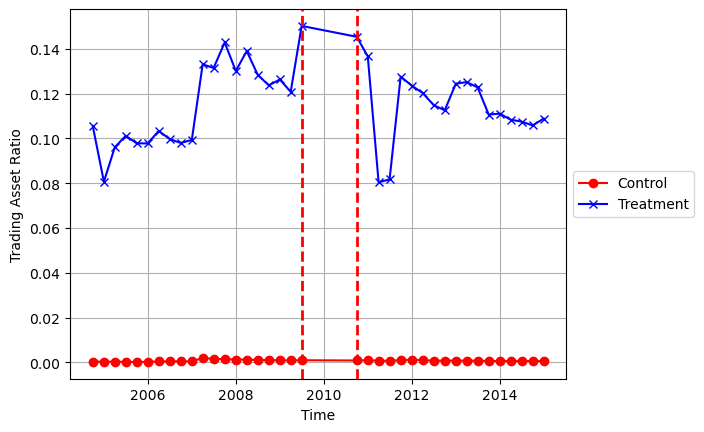

In [47]:
new_dataplot(nopro_df)

### With PSM

We choose not to include too many quarters and only include those where after_DFA_1 = 0 (pre-announcement). Otherwise, the model gets more precise and PSM doesn't work.

In [48]:
pro_df = df.copy()
pro_df = pro_df[pro_df['after_DFA_1'] == 0]

Then, we calculated the propensity score via logistic regression model for every dataset and append its value in a new column "propensity_scores".

In [49]:
# Logistic Regression Model

# Define predictor variables (features) in X and the binary treatment variable in y
X = pro_df[[
        # "bhc_avgtradingratio", 
        # "after_DFA_1",
        "dep_roa1", 
        "dep_lnassets", 
        "dep_cir",
        "dep_depositratio",
        "dep_loans_REratio",
        "dep_liquidity",
        "dep_cpp_bankquarter"
    ]]

X = sm.add_constant(X)  # Add a constant (intercept) term

y = pro_df['treat_3_b_avg']  # binary treatment variable (0 or 1)

# Create and fit a logistic regression model to calculate propensity scores
logistic_model = sm.Logit(y, X)
logistic_results = logistic_model.fit()

# Get the predicted probabilities (propensity scores)
propensity_scores = logistic_results.predict()
pro_df["propensity_scores"] = propensity_scores

logistic_results.summary()

Optimization terminated successfully.
         Current function value: 0.037724
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          treat_3_b_avg   No. Observations:                24428
Model:                          Logit   Df Residuals:                    24420
Method:                           MLE   Df Model:                            7
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.5173
Time:                        04:46:18   Log-Likelihood:                -921.53
converged:                       True   LL-Null:                       -1909.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -8.9114      0.796    -11.198      0.000     -10.471      -7.352
dep_roa1               -0.0456     12.600     -0.004      0.997     -24.741      24.650
dep_lnassets            0.6183      0.035     17.612      0.000       0.549       0.687
dep_cir                 0.1199      0.302      0.397      0.691      -0.472       0.711
dep_depositratio       -4.4158      0.420    -10.525      0.000      -5.238      -3.593
dep_loans_REratio      -3.4309      0.345     -9.958      0.000      -4.106      -2.756
dep_liquidity          -4.0688      1.353     -3.006      0.003      -6.721      -1.416
dep_cpp_bankquarter    -0.4719      0.375     -1.260      0.208      -1.206       0.262
=======================================================================================
"""

We identify the first timestamp and use it to identify our control and treatment groups.

In [50]:
min_time_index = pro_df["time"].idxmin()
min_rssd9999 = pro_df.loc[min_time_index, "rssd9999"]

print(f"rssd9999: {min_rssd9999}, time: {pro_df.loc[min_time_index, 'time']}\n")

# Potential Control and Treatment Groups
control_groups = pro_df[(pro_df['treat_3_b_avg'] == 0) & (pro_df["rssd9999"] == min_rssd9999)]
treated_groups = pro_df[(pro_df['treat_3_b_avg'] == 1) & (pro_df["rssd9999"] == min_rssd9999)]

print(f"No. of Identified Controls: {len(control_groups)}, No. of Identified Treatments: {len(treated_groups)}")

# Check that control_groups and treated_groups do not have duplicated banks
# control_groups = control_groups.drop_duplicates()
# treated_groups = treated_groups.drop_duplicates()
# print(len(control_groups), len(treated_groups))

rssd9999: 20040930, time: 2004-09-30 00:00:00

No. of Identified Controls: 783, No. of Identified Treatments: 18


In [9]:
# Number of nearest neighbors to find
n_neighbors = 3

treated_propensity_scores = treated_groups['propensity_scores'].values.reshape(-1, 1)
control_propensity_scores = control_groups['propensity_scores'].values.reshape(-1, 1)

# Initialize and fit the Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors)
nn_model.fit(control_propensity_scores)

# Find the indices of the closest control banks for each treated bank
distances, indices = nn_model.kneighbors(treated_propensity_scores)

# Initialize an empty DataFrame to store matched pairs
ctl_list, trt_list = [], []

for i in range(len(treated_groups)):
    # Identifying Treatment Bank
    treatment_bank = treated_groups.iloc[i] 
    trt_list.append(treatment_bank["rssd9001"])    
    
    # Identifying 3 Control Banks that are the closet to the Treatment Bank
    control_indices = indices[i]
    control_banks = control_groups.iloc[control_indices] 
    for control_bhc in control_banks["rssd9001"]:
        ctl_list.append(control_bhc)
        
print(f"No. of Control: {len(ctl_list)}, No. of Treatment: {len(trt_list)}")
print(f"No. of Control & Treatment: {len(ctl_list) + len(trt_list)}")
print(f"No. of Unique Control & Treatment: {len(list(set(ctl_list))) + len(list(set(trt_list)))}")

No. of Control: 54, No. of Treatment: 18
No. of Control & Treatment: 72
No. of Unique Control & Treatment: 43


Since the No. of Control > No. of Treatment and No. of Control & Treatment != No. of Unique Control & Treatment, there are control banks that are selected multiple times, suggesting that they have a higher weight. With ctl_trt_list containing the list of the BHCs of banks belonging in both the Control and Treatment group, let us select their data sets.

In [10]:
pro_control, pro_treatment = pd.DataFrame(), pd.DataFrame()

for bhc in ctl_list:
    pro_control = pd.concat([pro_control, df[df["rssd9001"] == bhc]])
    
for bhc in trt_list:
    pro_treatment = pd.concat([pro_treatment, df[df["rssd9001"] == bhc]])

new_df = pd.concat([pro_control, pro_treatment]).reset_index(drop=True)

print("No. of Control:", len(pro_control))
print("No. of Treatment:", len(pro_treatment))
print("Total No. of Dataset:", len(new_df))
    
diff_df = ctl_trt_diff(new_df)
diff_df

No. of Control: 699
No. of Treatment: 362
Total No. of Dataset: 1061


Control            Treatment           Difference  \
                        Mean        SD       Mean        SD       Mean   
dep_lnassets       16.557286  1.696307  18.505845  2.647945  -1.948560   
dep_leverage        0.106559  0.037157   0.090089  0.019368   0.016470   
dep_roa1            0.003324  0.006172   0.001903  0.003133   0.001421   
dep_liquidity       0.077252  0.062797   0.063929  0.060005   0.013323   
dep_depositratio    0.506171  0.173863   0.354444  0.196752   0.151726   
dep_loans_REratio   0.467465  0.212799   0.478020  0.174506  -0.010555   
dep_cir             0.573300  0.257335   0.563033  0.936205   0.010267   

                             
                         SD  
dep_lnassets      -0.951638  
dep_leverage       0.017789  
dep_roa1           0.003038  
dep_liquidity      0.002792  
dep_depositratio  -0.022889  
dep_loans_REratio  0.038293  
dep_cir           -0.678870

In [51]:
t_test(new_df)

t-value        p-value
bhc_avgtradingratio    30.230948  4.537247e-132
dep_roa1               -4.396564   1.257994e-05
dep_leverage           -8.931633   3.178925e-18
dep_lnassets            9.899664   8.367900e-22
dep_creditrisk_total3   6.495351   1.504546e-10
dep_cir                -5.131353   3.663852e-07
dep_depositratio       -7.376793   4.289357e-13
dep_loans_REratio       3.499488   4.935582e-04
dep_liquidity          -7.661700   5.652421e-14
dep_cpp_bankquarter     0.595155   5.519186e-01

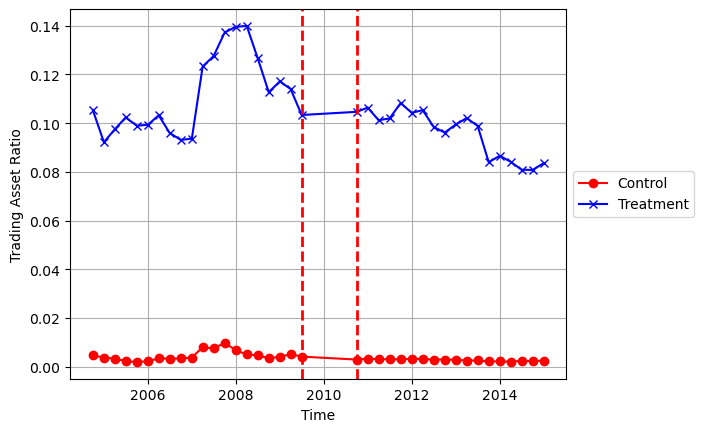

In [52]:
new_dataplot(new_df)

---

# <u>Difference-in-Differences Model</u>

Let us prepare our panel data for running DiD.

In [12]:
# Convert dataframe into panel (this is necessary to use the PanelOLS function)

# Dataset without Propensity Score Matching
nopro_panel_df = df.set_index(['rssd9001', 'rssd9999'])
del nopro_panel_df['time']

pro_panel_df = new_df.set_index(['rssd9001', 'rssd9999'])
del pro_panel_df['time']


### Model 1: Base Model (No PSM)
_Y<sub>i,t</sub> = α + β<sub>1</sub> * ( after_DFA_1<sub>t</sub> ) + β<sub>2</sub> * ( treat_3_b_avg<sub>i</sub> ) + β<sub>3</sub> * ( after_DFA_1<sub>t</sub> * treat_3_b_avg<sub>i</sub> ) + X<sub>i,t</sub> + ε<sub>i,t</sub>_


In [13]:
Y = nopro_panel_df['bhc_avgtradingratio']

interact_term = nopro_panel_df['after_DFA_1'] * nopro_panel_df['treat_3_b_avg']
nopro_panel_df["interact"] = interact_term

X = nopro_panel_df[['after_DFA_1', 'treat_3_b_avg', 'interact']]
X = sm.add_constant(X)

model = PanelOLS.from_formula('Y ~ X', data=nopro_panel_df)
results = model.fit()

print(results)
print(f"No. of Observations: {len(nopro_panel_df)}")

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.5274
Estimator:                   PanelOLS   R-squared (Between):              0.5856
No. Observations:               40026   R-squared (Within):              -0.0185
Date:                Fri, Oct 20 2023   R-squared (Overall):              0.5274
Time:                        04:27:33   Log-likelihood                 1.156e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.489e+04
Entities:                        2428   P-value                           0.0000
Avg Obs:                       16.485   Distribution:                 F(3,40022)
Min Obs:                       1.0000                                           
Max Obs:                       38.000   F-statistic (robust):          1.489e+04
                            

### Model 3: Base Model (With PSM): 
_Y<sub>i,t</sub> = α + β<sub>1</sub> * ( after_DFA_1<sub>t</sub> ) + β<sub>2</sub> * ( treat_3_b_avg<sub>i</sub> ) + β<sub>3</sub> * ( after_DFA_1<sub>t</sub> * treat_3_b_avg<sub>i</sub> ) + X<sub>i,t</sub> + ε<sub>i,t</sub>_


In [14]:
Y = pro_panel_df['bhc_avgtradingratio']

interact_term = pro_panel_df['after_DFA_1'] * pro_panel_df['treat_3_b_avg']
pro_panel_df["interact"] = interact_term

X = pro_panel_df[['after_DFA_1', 'treat_3_b_avg', 'interact']]
X = sm.add_constant(X)

model = PanelOLS.from_formula('Y ~ X', data=pro_panel_df)
results = model.fit()

print(results)
print(f"No. of Observations: {len(pro_panel_df)}")

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.5345
Estimator:                   PanelOLS   R-squared (Between):              0.4875
No. Observations:                1061   R-squared (Within):               0.0776
Date:                Fri, Oct 20 2023   R-squared (Overall):              0.5345
Time:                        04:27:33   Log-likelihood                    1798.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      404.57
Entities:                          43   P-value                           0.0000
Avg Obs:                       24.674   Distribution:                  F(3,1057)
Min Obs:                       1.0000                                           
Max Obs:                       143.00   F-statistic (robust):             404.57
                            

### Model 2: Fixed Effect Model (No PSM): 
*Y <sub>i,t</sub> = α + β * (after_DFA_1<sub>t</sub> * treat_3_b_avg<sub>i</sub>) + γ<sub>i</sub> + δ<sub>t</sub> + X<sub>i,t</sub> + ε<sub>i,t</sub>*

In [15]:
# Define the dependent variable Y
Y = nopro_panel_df['bhc_avgtradingratio']

# Define the treatment variable
nopro_panel_df['interact'] = nopro_panel_df['after_DFA_1'] * nopro_panel_df['treat_3_b_avg']

# Define the independent variable X
X = nopro_panel_df['interact']
X = sm.add_constant(X)

# No control + Fixed effect model
model = PanelOLS.from_formula('Y ~ X + EntityEffects + TimeEffects', data=nopro_panel_df)
results = model.fit()

print(results)
print(f"No. of Observations: {len(nopro_panel_df)}")

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.0478
Estimator:                   PanelOLS   R-squared (Between):             -0.0795
No. Observations:               40026   R-squared (Within):               0.0486
Date:                Fri, Oct 20 2023   R-squared (Overall):             -0.0973
Time:                        04:27:33   Log-likelihood                 1.518e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1887.1
Entities:                        2428   P-value                           0.0000
Avg Obs:                       16.485   Distribution:                 F(1,37560)
Min Obs:                       1.0000                                           
Max Obs:                       38.000   F-statistic (robust):             1887.1
                            

### Model 4: Fixed Effect Model (With PSM): 
*Y <sub>i,t</sub> = α + β * (after_DFA_1<sub>t</sub> * treat_3_b_avg<sub>i</sub>) + γ<sub>i</sub> + δ<sub>t</sub> + X<sub>i,t</sub> + ε<sub>i,t</sub>*

In [16]:
# Define the dependent variable Y
Y = pro_panel_df['bhc_avgtradingratio']

# Define the treatment variable
pro_panel_df['interact'] = pro_panel_df['after_DFA_1'] * pro_panel_df['treat_3_b_avg']

# Define the independent variable X
X = pro_panel_df['interact']
X = sm.add_constant(X)

# No control + Fixed effect model
model = PanelOLS.from_formula('Y ~ X + EntityEffects + TimeEffects', data=pro_panel_df)
results = model.fit()

print(results)
print(f"No. of Observations: {len(pro_panel_df)}")

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.0557
Estimator:                   PanelOLS   R-squared (Between):             -0.0603
No. Observations:                1061   R-squared (Within):               0.1009
Date:                Fri, Oct 20 2023   R-squared (Overall):             -0.0972
Time:                        04:27:33   Log-likelihood                    2674.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      57.808
Entities:                          43   P-value                           0.0000
Avg Obs:                       24.674   Distribution:                   F(1,980)
Min Obs:                       1.0000                                           
Max Obs:                       143.00   F-statistic (robust):             57.808
                            

---

Utilizing our Fixed Effect Model with Propensity Score Matching, we proceed to obtain:
- Top 5 largest coefficient of γ
- Top 5 smallest coeffcient of γ
- Top 5 smallest absolute cofficient of γ

In [17]:
# Extract the entity fixed effects coefficients
entity_effects_df = results.estimated_effects.reset_index()

# Sort entities by coefficient values in descending order (from most responsive to least responsive)
sorted_entities = entity_effects_df.sort_values(by='estimated_effects', ascending=False)
sorted_entities = sorted_entities.reset_index(drop=True)

# Create a mapping of "rssd9001" to "treat_3_b_avg" in pro_df
bhc_treat_map = pro_df[['rssd9001', 'treat_3_b_avg']].drop_duplicates()

sorted_entities

rssd9001  rssd9999  estimated_effects
0      2797498  20040930           0.348475
1      1039502  20071231           0.207601
2      1039502  20080331           0.206747
3      1039502  20070930           0.206484
4      1039502  20070630           0.203909
...        ...       ...                ...
1056   1062135  20140630          -0.048992
1057   1079562  20140930          -0.049011
1058   1039454  20090630          -0.049027
1059   1888193  20090630          -0.049044
1060   1062135  20140930          -0.049061

[1061 rows x 3 columns]

#### Top 5 largest coefficient of γ

In [18]:
top_eff = sorted_entities.iloc[:10, :].reset_index(drop=True)

# Add the "treat_3_b_avg" column based on "rssd9001"
top_eff['treat_3_b_avg'] = top_eff['rssd9001'].map(bhc_treat_map.set_index('rssd9001')['treat_3_b_avg'])

top_eff

rssd9001  rssd9999  estimated_effects  treat_3_b_avg
0   2797498  20040930           0.348475              1
1   1039502  20071231           0.207601              1
2   1039502  20080331           0.206747              1
3   1039502  20070930           0.206484              1
4   1039502  20070630           0.203909              1
5   1039502  20070331           0.202905              1
6   1039502  20080630           0.201084              1
7   1039502  20110930           0.198420              1
8   1039502  20130331           0.198120              1
9   1039502  20101231           0.197889              1

#### Top 5 smallest coefficient of γ

In [19]:
bottom_eff = sorted_entities.iloc[-10:, :].reset_index(drop=True)

# Add the "treat_3_b_avg" column based on "rssd9001"
bottom_eff['treat_3_b_avg'] = bottom_eff['rssd9001'].map(bhc_treat_map.set_index('rssd9001')['treat_3_b_avg'])

bottom_eff

rssd9001  rssd9999  estimated_effects  treat_3_b_avg
0   1079562  20090630          -0.047962              0
1   1062135  20090630          -0.048012              0
2   1826056  20090630          -0.048378              0
3   1055315  20090630          -0.048579              0
4   1079562  20140630          -0.048942              0
5   1062135  20140630          -0.048992              0
6   1079562  20140930          -0.049011              0
7   1039454  20090630          -0.049027              0
8   1888193  20090630          -0.049044              0
9   1062135  20140930          -0.049061              0

#### Top 5 smallest absolute coefficient of γ

In [20]:
# Calculate Absolute Values
absolute_values = sorted_entities['estimated_effects'].abs()

# Sort the Absolute Values
sorted_indices = absolute_values.argsort()

# Extract the top 5 smallest Absolute Values
smallest_abs = sorted_entities.iloc[sorted_indices[:10]].reset_index(drop=True)

# Use map to add the "treat_3_b_avg" column based on "rssd9001"
smallest_abs['treat_3_b_avg'] = smallest_abs['rssd9001'].map(bhc_treat_map.set_index('rssd9001')['treat_3_b_avg'])

smallest_abs

rssd9001  rssd9999  estimated_effects  treat_3_b_avg
0   1883693  20050331          -0.000238              1
1   1883693  20080930           0.000249              1
2   1883693  20041231          -0.000339              1
3   1883693  20050630           0.000419              1
4   1883693  20051231          -0.000439              1
5   1883693  20060331          -0.000682              1
6   1883693  20050930          -0.000705              1
7   1883693  20081231          -0.000823              1
8   1417360  20050630          -0.001057              1
9   1107205  20110930          -0.001307              1